In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

# Understanding SLIC Output

In [2]:
# load image
im = cv2.imread('test2.png')

# slic
labels = segmentation.slic(im, compactness=100, n_segments=20)


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


In [14]:
labels.shape

(900, 1600)

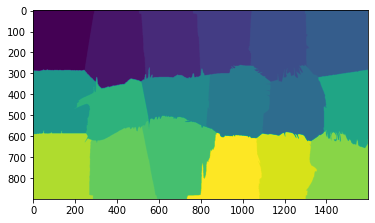

In [10]:
import matplotlib.pyplot as plt

plt.imshow(labels)

In [3]:

labels = labels.reshape(im.shape[0]*im.shape[1]) # SEGMENTED SLIC Output

u_labels = np.unique(labels)      # TOTAL Unique Labels


In [12]:
labels.shape

(1440000,)

### Compare 'labels' and 'u_labels'

In [38]:
labels, labels.max()

(array([[ 0,  0,  0, ...,  5,  5,  5],
        [ 0,  0,  0, ...,  5,  5,  5],
        [ 0,  0,  0, ...,  5,  5,  5],
        ...,
        [15, 15, 15, ..., 14, 14, 14],
        [15, 15, 15, ..., 14, 14, 14],
        [15, 15, 15, ..., 14, 14, 14]]),
 17)

In [15]:
u_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [4]:
l_inds = [] # Labelled Indices

for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

In [72]:
l_inds, len(l_inds), len(l_inds[0]), len(l_inds[1])

([array([     0,      1,      2, ..., 462434, 462435, 464000]),
  array([   293,    294,    295, ..., 595528, 595529, 595530]),
  array([   505,    506,    507, ..., 520741, 522142, 522143]),
  array([   764,    765,    766, ..., 496822, 496823, 498400]),
  array([  1045,   1046,   1047, ..., 546785, 546786, 546787]),
  array([  1299,   1300,   1301, ..., 510171, 510172, 511763]),
  array([417297, 417298, 418897, ..., 998126, 998127, 999712]),
  array([418590, 420186, 420187, ..., 975464, 975465, 975466]),
  array([437356, 438955, 438956, ..., 895207, 895208, 896807]),
  array([454449, 454450, 454467, ..., 944004, 944005, 944007]),
  array([ 455995,  455997,  455998, ..., 1051182, 1051183, 1051184]),
  array([ 510704,  512303,  512304, ..., 1009904, 1009905, 1011504]),
  array([ 803836,  803837,  805418, ..., 1439132, 1439133, 1439134]),
  array([ 886919,  888507,  888508, ..., 1438990, 1438991, 1438992]),
  array([ 916600,  918200,  918201, ..., 1439997, 1439998, 1439999]),
  array([ 

In [21]:
for i in range(len(u_labels)):
    print(np.where(labels == u_labels[i])) # Returns Values, Indices 

(array([  0,   0,   0, ..., 289, 289, 290]), array([ 0,  1,  2, ..., 34, 35,  0]))
(array([  0,   0,   0, ..., 372, 372, 372]), array([293, 294, 295, ..., 328, 329, 330]))
(array([  0,   0,   0, ..., 325, 326, 326]), array([505, 506, 507, ..., 741, 542, 543]))
(array([  0,   0,   0, ..., 310, 310, 311]), array([764, 765, 766, ..., 822, 823, 800]))
(array([  0,   0,   0, ..., 341, 341, 341]), array([1045, 1046, 1047, ..., 1185, 1186, 1187]))
(array([  0,   0,   0, ..., 318, 318, 319]), array([1299, 1300, 1301, ..., 1371, 1372, 1363]))
(array([260, 260, 261, ..., 623, 623, 624]), array([1297, 1298, 1297, ..., 1326, 1327, 1312]))
(array([261, 262, 262, ..., 609, 609, 609]), array([ 990,  986,  987, ..., 1064, 1065, 1066]))
(array([273, 274, 274, ..., 559, 559, 560]), array([556, 555, 556, ..., 807, 808, 807]))
(array([284, 284, 284, ..., 590, 590, 590]), array([49, 50, 67, ...,  4,  5,  7]))
(array([284, 284, 284, ..., 656, 656, 656]), array([1595, 1597, 1598, ..., 1582, 1583, 1584]))
(ar

# Neural Net

In [5]:
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 100, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(1):
            self.conv2.append( nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(100) )
        self.conv3 = nn.Conv2d(100, 100, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(100)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [6]:
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )

data = Variable(data)

In [7]:
data.size()

torch.Size([1, 3, 900, 1600])

In [8]:
model = MyNet(data.size(1))

model.train()

loss_fn = torch.nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.1)



In [9]:
label_colours = np.random.randint(255,size=(100,3))


## Below cell is the MAIN, Overall Code, we will break it down in subsequent cells

In [ ]:
####################### PART - 1 #############################


for batch_idx in range(2):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, 100 )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
    #cv2_imshow( "output", im_target_rgb )
    #cv2.waitKey(10)
    plt.imshow(im_target_rgb )
  
    
    
    
###################### PART - 2 ################################

    
    # superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', args.maxIter, ':', nLabels, loss.item())

    if nLabels <= args.minLabels:
        print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
        break

### Explanation of PART - 1 of the above cell

In [56]:
output = model( data )[0]

# [0] removes the "Btach size"- N variable from the first axis, if you dont keep it, the output tensor shape will be:

#torch.Size([1, 100, 900, 1600])

In [54]:
output

tensor([[[[ 1.0261, -0.7214, -0.7105,  ..., -0.7105, -0.7217, -2.1185],
          [ 1.4078,  0.0367,  0.0635,  ...,  0.0635,  0.0212, -1.4317],
          [ 1.3632,  0.0889,  0.1374,  ...,  0.1374,  0.1346, -1.4765],
          ...,
          [ 1.4292,  0.0823,  0.0993,  ...,  0.1374,  0.1346, -1.4765],
          [ 1.2607,  0.0269,  0.0539,  ...,  0.0539,  0.1052, -1.3954],
          [ 0.0710,  0.4089,  0.4000,  ...,  0.4000,  0.3840, -0.0976]],

         [[ 0.4626, -0.4847, -0.5817,  ..., -0.5817, -0.5308, -0.5901],
          [ 0.9670,  0.1453,  0.1821,  ...,  0.1821,  0.2141, -0.1631],
          [ 1.0315,  0.1999,  0.2236,  ...,  0.2236,  0.2595, -0.1318],
          ...,
          [ 0.9858,  0.1613,  0.2139,  ...,  0.2236,  0.2595, -0.1318],
          [ 1.0742,  0.2982,  0.2429,  ...,  0.2429,  0.2212, -0.0571],
          [ 0.9951, -0.7467, -0.7446,  ..., -0.7446, -0.6774, -0.5528]],

         [[-0.5102,  0.3691,  0.3351,  ...,  0.3351,  0.2633,  0.6971],
          [-0.6118, -1.9118, -

In [57]:
output.shape 

# 100 = No. of channels that we specified in the CONV layers, TODO: make 100 as the last axis (see below)

torch.Size([100, 900, 1600])

In [58]:
output = output.permute( 1, 2, 0 ).contiguous().view( -1, 100 ) 

# we move 100 to the last axis, 900 to the first and 1600 to the 2nd axis and then mul 900*1600

# -1 means, we dont know the no. of rows exactly BUT we are sure of the no. of columns i.e. 100 so we 
# leave it upto PyTorch to decide it

# contiguous() just makes a copy (some performance tricks)

output.shape

torch.Size([1440000, 100])

In [74]:
ignore, target = torch.max( output, 1 ) # Returns Values, Indices # NOTE: dim = 1 means ROWS in PyTorch!!!!

ignore, target

(tensor([5.5238, 4.6419, 4.6846,  ..., 5.9896, 5.8902, 4.3096],
        grad_fn=<MaxBackward0>),
 tensor([59, 34, 34,  ..., 92, 92, 92]))

In [60]:
print(torch.max(output,1))


torch.return_types.max(
values=tensor([5.5238, 4.6419, 4.6846,  ..., 5.9896, 5.8902, 4.3096],
       grad_fn=<MaxBackward0>),
indices=tensor([59, 34, 34,  ..., 92, 92, 92]))


In [75]:
im_target = target.data.cpu().numpy()
nLabels = len(np.unique(im_target))

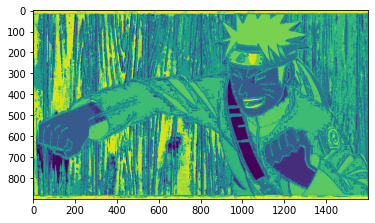

In [67]:
im_target_2 = np.resize(im_target, (900,1600))
plt.imshow(im_target_2)

In [76]:
im_target, len(im_target)

(array([59, 34, 34, ..., 92, 92, 92]), 1440000)

In [51]:
nLabels

100

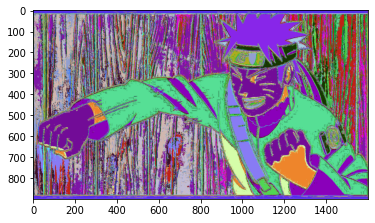

In [68]:
im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
#cv2_imshow( "output", im_target_rgb )
#cv2.waitKey(10)
plt.imshow(im_target_rgb )

In [ ]:
######### OVERALL combination of PART -1 ############

for batch_idx in range(2):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, 100 )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy() # Already plotted this 3 cells above, see that
    nLabels = len(np.unique(im_target))
    
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
    #cv2_imshow( "output", im_target_rgb )
    #cv2.waitKey(10)
    plt.imshow(im_target_rgb )
  
    

### Explanation of PART - 2 

In [ ]:
# superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
            
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
        
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', args.maxIter, ':', nLabels, loss.item())

    if nLabels <= args.minLabels:
        print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
        break

In [77]:
 for i in range(len(l_inds)):
    labels_per_sp = im_target[ l_inds[ i ] ]
    u_labels_per_sp = np.unique( labels_per_sp )
    hist = np.zeros( len(u_labels_per_sp) )

In [78]:
len(l_inds), len(im_target)

(18, 1440000)

In [82]:
labels_per_sp, labels_per_sp.max() # max() = 99 because, as of now nLabels = 100

(array([84, 84, 84, ..., 92, 92, 92]), 99)

In [83]:
u_labels_per_sp = np.unique( labels_per_sp )
hist = np.zeros( len(u_labels_per_sp) )

In [88]:
u_labels_per_sp, len(u_labels_per_sp)

(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 98)

In [91]:
for j in range(len(hist)):
    hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]

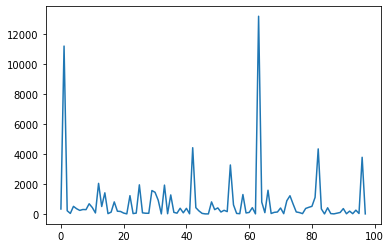

In [90]:
plt.plot(hist)

In [92]:
target = torch.from_numpy( im_target )

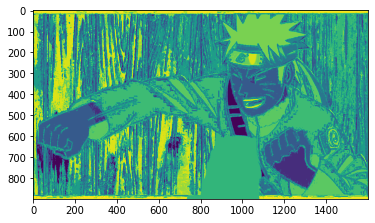

In [94]:
target_2 = np.resize(target, (900,1600))
plt.imshow(target_2)

In [95]:
torch.cuda.empty_cache() # PyTorch thing

#### Mixing up All Together

0 / 17 : 100 4.310654163360596
1 / 17 : 68 4.189214706420898


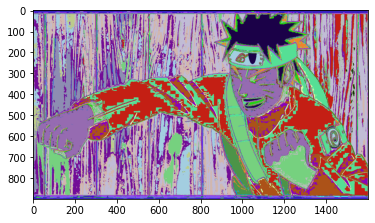

In [100]:
for batch_idx in range(2):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1,100 )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
 
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
    #cv2_imshow( "output", im_target_rgb )
    #cv2.waitKey(10)
    plt.imshow(im_target_rgb )
  
    # superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )     
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
        
    target = torch.from_numpy( im_target )

    #target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', i, ':', nLabels, loss.item())

